In [18]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [ ]:
transform = transform.Compose([
    transform.Resize(224),
    transform.CenterCrop(224),
    transform.ToTensor(),
    transform.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [20]:
test_dir = '/home/oz31/code/personal/python/training-skripsi/dataset/Test/'

test_dataset = ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [21]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Load saved weights, ignoring mismatched classifier.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('is cuda available?', torch.cuda.is_available())

# Load state dict with partial matching
state_dict = torch.load('mobilenet_v2.pth', map_location=device)
# Remove classifier.1 weights from state dict to avoid mismatch
num_classes = 10  # Hardcode to match trained model
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
# Load the compatible weights
model.load_state_dict(state_dict, strict=False) 
model = model.to(device)
model.eval()

is cuda available? True


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%\n")

report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True, zero_division=0)

print(f"{'Class':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Accuracy':<10}")
print("-" * 65)
for class_name in test_dataset.classes:
    cls_report = report[class_name]
    precision = cls_report['precision']
    recall = cls_report['recall']
    f1 = cls_report['f1-score']
    support = cls_report['support']
    acc = (recall * support) / support
    print(f"{class_name:<25} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f} {acc*100:<10.2f}")

Test Accuracy: 89.84%

Class                     Precision  Recall     F1-Score   Accuracy  
-----------------------------------------------------------------
algal_spot                0.97       0.98       0.98       98.00     
brown-blight              0.90       0.87       0.88       87.38     
gray-blight               0.44       0.56       0.49       55.56     
healthy                   0.85       0.97       0.91       97.50     
helopeltis                0.93       0.98       0.96       98.50     
leaf-rust                 1.00       0.95       0.98       95.41     
red-rust                  0.44       1.00       0.62       100.00    
red-spider-infested       0.70       1.00       0.82       100.00    
red-spot                  0.99       0.67       0.80       67.00     
white-spot                0.76       1.00       0.87       100.00    


/tmp/ipykernel_473848/2659207966.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_473848/2659207966.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_473848/2659207966.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_473848/2659207966.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

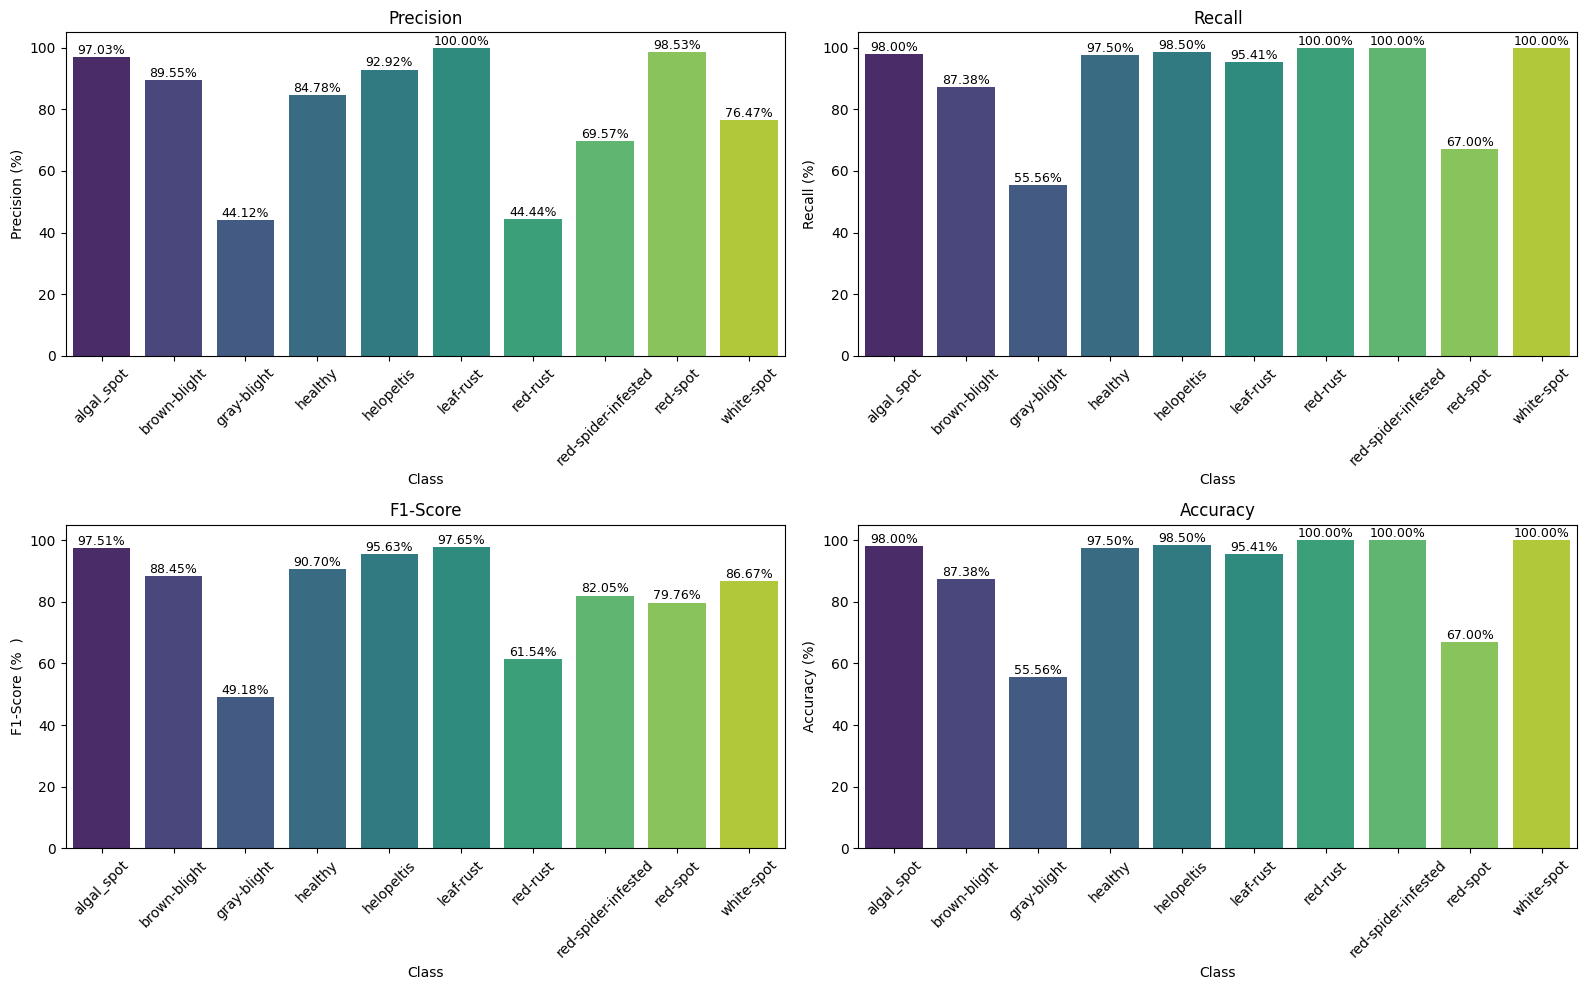

In [23]:

import matplotlib.pyplot as plt
import seaborn as sns

# ambil metric masing-masing class
class_names = list(test_dataset.classes)
precisions = [report[cls]['precision'] * 100 for cls in class_names]
recalls = [report[cls]['recall'] * 100 for cls in class_names]
f1_scores = [report[cls]['f1-score'] * 100 for cls in class_names]
accuracies = [report[cls]['recall'] * 100 for cls in class_names]

# setup plot
plt.figure(figsize=(16, 10))
metrics = [precisions, recalls, f1_scores, accuracies]
titles = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
ylabels = ['Precision (%)', 'Recall (%)', 'F1-Score (%  )', 'Accuracy (%)']

for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
    plt.title(titles[i])
    plt.xlabel('Class')
    plt.ylabel(ylabels[i])    
    plt.ylim(0, 105)
    plt.xticks(rotation=45)
    
    for idx, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1,
                f'{height:.2f}%', ha="center", fontsize=9)

plt.tight_layout()
plt.show()